In [341]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV

In [17]:
!ls data

sat.trn sat.tst


In [18]:
train, test = np.loadtxt('data/sat.trn'), np.loadtxt('data/sat.tst')

In [19]:
train

array([[ 92., 115., 120., ..., 113.,  87.,   3.],
       [ 84., 102., 106., ..., 104.,  79.,   3.],
       [ 84., 102., 102., ..., 104.,  79.,   3.],
       ...,
       [ 68.,  75., 108., ..., 104.,  85.,   4.],
       [ 71.,  87., 108., ..., 104.,  85.,   4.],
       [ 71.,  91., 100., ..., 100.,  81.,   4.]])

In [20]:
test

array([[ 80., 102., 102., ..., 113.,  87.,   3.],
       [ 76., 102., 102., ..., 104.,  83.,   3.],
       [ 80.,  98., 106., ...,  96.,  75.,   4.],
       ...,
       [ 56.,  68.,  91., ...,  92.,  74.,   5.],
       [ 56.,  68.,  87., ...,  92.,  70.,   5.],
       [ 60.,  71.,  91., ..., 108.,  92.,   5.]])

In [21]:
print(train.shape, test.shape)

(4435, 37) (2000, 37)


In [22]:
# Separate labels into different vectors
y_train, y_test = train[:,-1], test[:,-1]

In [23]:
y_train, y_test

(array([3., 3., 3., ..., 4., 4., 4.]), array([3., 3., 4., ..., 5., 5., 5.]))

In [24]:
print(len(y_train), len(y_test))

4435 2000


In [25]:
# Separate 3x3x4 pixel neighborhood samples into train and test feature samples
X_train, X_test = train[:,:-1], test[:,:-1]

In [26]:
X_train

array([[ 92., 115., 120., ..., 107., 113.,  87.],
       [ 84., 102., 106., ...,  99., 104.,  79.],
       [ 84., 102., 102., ...,  99., 104.,  79.],
       ...,
       [ 68.,  75., 108., ..., 100., 104.,  85.],
       [ 71.,  87., 108., ...,  91., 104.,  85.],
       [ 71.,  91., 100., ...,  91., 100.,  81.]])

## Exploratory Data Analysis

In [27]:
# Determine class count for each label in training set
def class_counts(y):
    labels, labels_inverse, label_counts = np.unique(y, return_inverse=True, return_counts=True)
    return labels, labels_inverse, label_counts

In [28]:
labels, labels_inverse, label_counts = class_counts(y_train)

<ipython-input-383-33252419d205>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);


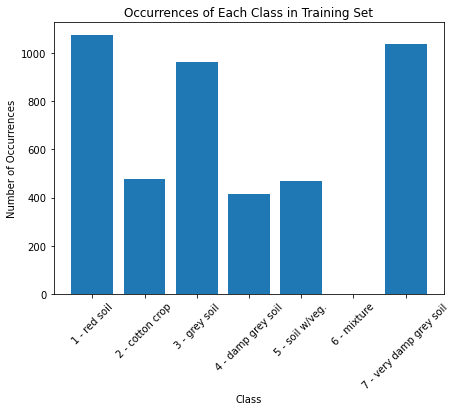

In [383]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(labels, label_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Occurrences of Each Class in Training Set')
ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);

In [30]:
# Calculate and plot mean spectral signature for each class
means = []
for idx,label in enumerate(labels):
    means.append(np.mean(X_train[labels_inverse==idx,16:20], axis=0))
# 

In [31]:
means

[array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 array([69.01252408, 77.42196532, 81.59248555, 64.12524085])]

In [32]:
# Calculate cosine similarity of mean vectors

In [33]:
# 3D Histogram of Pixel Neighborhood?

In [34]:
# Plot Average intensity for neighborhood across each band

In [35]:
# Scatter plot of mean vectors for each class

## Sanity Check

In [36]:
X_train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.])

In [37]:
X_train[0,16:20]

array([ 92., 112., 118.,  85.])

In [38]:
train[0,:]

array([ 92., 115., 120.,  94.,  84., 102., 106.,  79.,  84., 102., 102.,
        83., 101., 126., 133., 103.,  92., 112., 118.,  85.,  84., 103.,
       104.,  81., 102., 126., 134., 104.,  88., 121., 128., 100.,  84.,
       107., 113.,  87.,   3.])

## Baseline Model

In [39]:
# Classify each sample by closest distance to mean vector
mean_dict = {label: means[i] for i,label in enumerate(labels)} # Create dictionary of mean spectral vector per class label

In [40]:
mean_dict 

{1.0: array([ 62.8255597 ,  95.29384328, 108.12313433,  88.60074627]),
 2.0: array([ 48.83924843,  39.91440501, 113.88935282, 118.31106472]),
 3.0: array([ 87.47866805, 105.49843913, 110.5962539 ,  87.45681582]),
 4.0: array([77.40963855, 90.94457831, 95.61445783, 75.35421687]),
 5.0: array([59.5893617 , 62.26595745, 83.02340426, 69.95319149]),
 7.0: array([69.01252408, 77.42196532, 81.59248555, 64.12524085])}

In [41]:
def euclidean_distance(a,b):
    return np.sqrt(sum((a-b)**2))

In [42]:
euclidean_distance(train[-1,16:20], mean_dict[3.0])

24.776905414321906

In [43]:
def min_distance_classifier(X, mean_dict,labels):
    predicts = []
    label_dict = {num:label for num,label in zip(np.arange(len(labels)), labels)}
    for sample in X[:,16:20]:
        mean_index = np.argmin([euclidean_distance(sample, mean_vector) for mean_vector in mean_dict.values()])
        predicts.append(label_dict[mean_index])
    return np.array(predicts)

In [44]:
y_predict = min_distance_classifier(X_train, mean_dict, labels)

In [45]:
y_predict

array([3., 3., 4., ..., 4., 4., 4.])

In [46]:
np.count_nonzero(y_predict == y_train)/len(X_train)

0.7641488162344983

In [47]:
y_test_predict = min_distance_classifier(X_test, mean_dict, labels)

In [48]:
np.count_nonzero(y_test_predict == y_test)/len(X_test)

0.7685

In [49]:
y_test_predict

array([3., 3., 4., ..., 5., 7., 1.])

In [50]:
y_test

array([3., 3., 4., ..., 5., 5., 5.])

## Neural Network

In [334]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

In [280]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc.fit(y_train.reshape(-1,1))

y_trn_1hot = enc.transform(y_train.reshape(-1,1)).toarray()


In [283]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_trn_scaled = scaler.transform(X_train)


NameError: name 'StandardScaler' is not defined

In [335]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
hidden_units = 100
n_classes = 6

In [338]:
def create_model(X, n_classes, opt='Adam', hidden_units=100):
    np.random.seed(42)

    n_samples, n_feats = X.shape

    model = Sequential() # sequence of layers

    hidden_layer = Dense(units=hidden_units,
                    input_dim=n_feats,
                    kernel_initializer='constant',
                    activation='softsign')

    hidden_layer_2 = Dense(units=hidden_units,
                    kernel_initializer='constant',
                    activation='softsign')

    outputlayer = Dense(units=n_classes,
                    input_dim=hidden_units,
                    kernel_initializer='uniform',
                    activation='softmax')

    model.add(hidden_layer)
    model.add(hidden_layer_2)
    model.add(hidden_layer_2)
    model.add(outputlayer)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, metrics=["accuracy"])
    return model

In [337]:
model = create_model(X_trn_scaled, n_classes, opt)

In [339]:
history = model.fit(X_trn_scaled, y_trn_1hot, epochs=350, batch_size=50, verbose=1, validation_split=0)


Epoch 1/350
89/89 [==============================] - 1s 2ms/step - loss: 1.6780 - accuracy: 0.2492 - precision_35: 1.0000 - recall_35: 0.0011    
Epoch 2/350
89/89 [==============================] - 0s 2ms/step - loss: 1.3523 - accuracy: 0.3360 - precision_35: 0.7815 - recall_35: 0.1008
Epoch 3/350
89/89 [==============================] - 0s 2ms/step - loss: 1.2868 - accuracy: 0.3517 - precision_35: 0.6700 - recall_35: 0.1057
Epoch 4/350
89/89 [==============================] - 0s 2ms/step - loss: 1.2348 - accuracy: 0.3822 - precision_35: 0.6676 - recall_35: 0.1051
Epoch 5/350
89/89 [==============================] - 0s 2ms/step - loss: 1.0392 - accuracy: 0.5880 - precision_35: 0.8495 - recall_35: 0.2902
Epoch 6/350
89/89 [==============================] - 0s 2ms/step - loss: 0.7642 - accuracy: 0.7680 - precision_35: 0.8509 - recall_35: 0.6149
Epoch 7/350
89/89 [==============================] - 0s 2ms/step - loss: 0.6352 - accuracy: 0.7986 - precision_35: 0.8460 - recall_35: 0.7508
Ep

89/89 [==============================] - 0s 1ms/step - loss: 0.3257 - accuracy: 0.8672 - precision_35: 0.8829 - recall_35: 0.8552
Epoch 59/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3198 - accuracy: 0.8706 - precision_35: 0.8884 - recall_35: 0.8528
Epoch 60/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3260 - accuracy: 0.8681 - precision_35: 0.8836 - recall_35: 0.8523
Epoch 61/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3195 - accuracy: 0.8719 - precision_35: 0.8873 - recall_35: 0.8573
Epoch 62/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3143 - accuracy: 0.8742 - precision_35: 0.8893 - recall_35: 0.8604
Epoch 63/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3171 - accuracy: 0.8728 - precision_35: 0.8866 - recall_35: 0.8607
Epoch 64/350
89/89 [==============================] - 0s 1ms/step - loss: 0.3169 - accuracy: 0.8719 - precision_35: 0.8872 - recall_35: 0.8600
Epoch 65/350

89/89 [==============================] - 0s 1ms/step - loss: 0.2986 - accuracy: 0.8764 - precision_35: 0.8948 - recall_35: 0.8609
Epoch 116/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2902 - accuracy: 0.8843 - precision_35: 0.8984 - recall_35: 0.8710
Epoch 117/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2955 - accuracy: 0.8852 - precision_35: 0.8992 - recall_35: 0.8670
Epoch 118/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2929 - accuracy: 0.8773 - precision_35: 0.8935 - recall_35: 0.8625
Epoch 119/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2874 - accuracy: 0.8857 - precision_35: 0.9015 - recall_35: 0.8710
Epoch 120/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2897 - accuracy: 0.8848 - precision_35: 0.8991 - recall_35: 0.8679
Epoch 121/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2935 - accuracy: 0.8823 - precision_35: 0.8978 - recall_35: 0.8658
Epoch 

Epoch 172/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2623 - accuracy: 0.8967 - precision_35: 0.9111 - recall_35: 0.8823
Epoch 173/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.8945 - precision_35: 0.9066 - recall_35: 0.8839
Epoch 174/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2624 - accuracy: 0.8938 - precision_35: 0.9072 - recall_35: 0.8791
Epoch 175/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2628 - accuracy: 0.8979 - precision_35: 0.9109 - recall_35: 0.8855
Epoch 176/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2667 - accuracy: 0.8945 - precision_35: 0.9092 - recall_35: 0.8830
Epoch 177/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2652 - accuracy: 0.8933 - precision_35: 0.9081 - recall_35: 0.8803
Epoch 178/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2638 - accuracy: 0.8927 - precision_35: 0.9051 - recall_35:

89/89 [==============================] - 0s 1ms/step - loss: 0.2412 - accuracy: 0.9064 - precision_35: 0.9182 - recall_35: 0.8963
Epoch 229/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2350 - accuracy: 0.9091 - precision_35: 0.9175 - recall_35: 0.8981
Epoch 230/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2364 - accuracy: 0.9033 - precision_35: 0.9148 - recall_35: 0.8931
Epoch 231/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2343 - accuracy: 0.9114 - precision_35: 0.9199 - recall_35: 0.9006
Epoch 232/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2397 - accuracy: 0.9057 - precision_35: 0.9163 - recall_35: 0.8958
Epoch 233/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2420 - accuracy: 0.9055 - precision_35: 0.9153 - recall_35: 0.8945
Epoch 234/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2369 - accuracy: 0.9064 - precision_35: 0.9170 - recall_35: 0.8938
Epoch 

Epoch 285/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2213 - accuracy: 0.9161 - precision_35: 0.9251 - recall_35: 0.9055
Epoch 286/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2213 - accuracy: 0.9127 - precision_35: 0.9218 - recall_35: 0.9037
Epoch 287/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2194 - accuracy: 0.9150 - precision_35: 0.9243 - recall_35: 0.9055
Epoch 288/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2152 - accuracy: 0.9143 - precision_35: 0.9246 - recall_35: 0.9064
Epoch 289/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2217 - accuracy: 0.9179 - precision_35: 0.9276 - recall_35: 0.9098
Epoch 290/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2121 - accuracy: 0.9182 - precision_35: 0.9253 - recall_35: 0.9078
Epoch 291/350
89/89 [==============================] - 0s 1ms/step - loss: 0.2143 - accuracy: 0.9166 - precision_35: 0.9257 - recall_35:

89/89 [==============================] - 0s 1ms/step - loss: 0.2052 - accuracy: 0.9209 - precision_35: 0.9295 - recall_35: 0.9150
Epoch 342/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1964 - accuracy: 0.9269 - precision_35: 0.9338 - recall_35: 0.9186
Epoch 343/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1992 - accuracy: 0.9213 - precision_35: 0.9290 - recall_35: 0.9141
Epoch 344/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1958 - accuracy: 0.9251 - precision_35: 0.9320 - recall_35: 0.9179
Epoch 345/350
89/89 [==============================] - 0s 2ms/step - loss: 0.1975 - accuracy: 0.9240 - precision_35: 0.9307 - recall_35: 0.9175
Epoch 346/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1978 - accuracy: 0.9227 - precision_35: 0.9303 - recall_35: 0.9172
Epoch 347/350
89/89 [==============================] - 0s 1ms/step - loss: 0.1950 - accuracy: 0.9231 - precision_35: 0.9299 - recall_35: 0.9157
Epoch 

In [237]:
history.history

{'loss': [0.3052085340023041,
  0.2963157594203949,
  0.3032892346382141,
  0.30303138494491577,
  0.296730101108551,
  0.2979796230792999,
  0.3015426993370056,
  0.2961179316043854,
  0.29113855957984924,
  0.29213887453079224,
  0.30815356969833374,
  0.28868579864501953,
  0.2939971387386322,
  0.2841227948665619,
  0.28662359714508057,
  0.2972811162471771,
  0.2941512167453766,
  0.2943926751613617,
  0.2906618118286133,
  0.29063040018081665,
  0.28554269671440125,
  0.28373661637306213,
  0.2890125513076782,
  0.2789667546749115,
  0.2806715965270996,
  0.28155645728111267,
  0.28527697920799255,
  0.27810341119766235,
  0.28052330017089844,
  0.2757915258407593,
  0.28586089611053467,
  0.2735039293766022,
  0.2725268304347992,
  0.276482492685318,
  0.27836647629737854,
  0.27129024267196655,
  0.27246764302253723,
  0.27131426334381104,
  0.2772705554962158,
  0.2822965085506439,
  0.27032461762428284,
  0.27262523770332336,
  0.274924635887146,
  0.2640242874622345,
  0.271

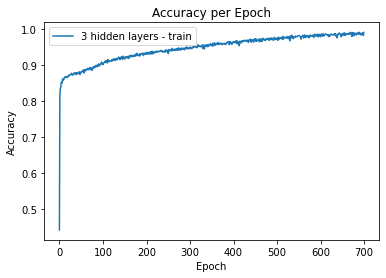

In [317]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'], label = '3 hidden layers - train')
#ax.plot(history.epoch, history.history['val_accuracy'], label = '3 hidden layers - val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()

In [328]:
model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())  # Calculate performance metrics on unseen test data

63/63 [==============================] - 0s 746us/step - loss: 0.2546 - accuracy: 0.9035 - precision_34: 0.9110 - recall_34: 0.8960


[0.2546454668045044,
 0.9035000205039978,
 0.9110320210456848,
 0.8960000276565552]

In [ ]:
model.predict(X_train[:,16:20])

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
yhat_trn = clf.predict(X_train)
print(accuracy_score(y_train, yhat_trn))
yhat = clf.predict(X_test)
print(accuracy_score(y_test, yhat))

1.0
0.849


In [ ]:
#print(y_train.shape, y_predict.shape)
print(accuracy_score(y_train,y_predict))

In [367]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_trn_rf = clf.predict(X_train)
print(accuracy_score(y_train, y_trn_rf))
y_rf = clf.predict(X_test)
print(accuracy_score(y_test, y_rf))

0.9713641488162345
0.903


## Grid Search

In [360]:
modelo = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, X=X_trn_scaled, n_classes=6, opt=opt)

In [374]:
# Set grid search parameters
param_grid = dict(epochs=[300, 350, 400], batch_size=[40,50,60])
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_trn_scaled, y_trn_1hot)

Epoch 1/350
111/111 [==============================] - 0s 918us/step - loss: 1.4218 - accuracy: 0.3193
Epoch 2/350
111/111 [==============================] - 0s 885us/step - loss: 0.9668 - accuracy: 0.6304
Epoch 3/350
111/111 [==============================] - 0s 883us/step - loss: 0.6198 - accuracy: 0.7957
Epoch 4/350
111/111 [==============================] - 0s 894us/step - loss: 0.5157 - accuracy: 0.8176
Epoch 5/350
111/111 [==============================] - 0s 854us/step - loss: 0.4674 - accuracy: 0.8262
Epoch 6/350
111/111 [==============================] - 0s 929us/step - loss: 0.4468 - accuracy: 0.8340
Epoch 7/350
111/111 [==============================] - 0s 948us/step - loss: 0.4370 - accuracy: 0.8325
Epoch 8/350
111/111 [==============================] - 0s 937us/step - loss: 0.4243 - accuracy: 0.8381
Epoch 9/350
111/111 [==============================] - 0s 924us/step - loss: 0.4267 - accuracy: 0.8383
Epoch 10/350
111/111 [==============================] - 0s 937us/step - l

111/111 [==============================] - 0s 869us/step - loss: 0.3083 - accuracy: 0.8744
Epoch 80/350
111/111 [==============================] - 0s 870us/step - loss: 0.3022 - accuracy: 0.8818
Epoch 81/350
111/111 [==============================] - 0s 798us/step - loss: 0.3052 - accuracy: 0.8834
Epoch 82/350
111/111 [==============================] - 0s 895us/step - loss: 0.2992 - accuracy: 0.8816
Epoch 83/350
111/111 [==============================] - 0s 862us/step - loss: 0.3014 - accuracy: 0.8794
Epoch 84/350
111/111 [==============================] - 0s 856us/step - loss: 0.2987 - accuracy: 0.8814
Epoch 85/350
111/111 [==============================] - 0s 853us/step - loss: 0.2964 - accuracy: 0.8800
Epoch 86/350
111/111 [==============================] - 0s 831us/step - loss: 0.2957 - accuracy: 0.8841
Epoch 87/350
111/111 [==============================] - 0s 894us/step - loss: 0.2992 - accuracy: 0.8818
Epoch 88/350
111/111 [==============================] - 0s 894us/step - loss:

111/111 [==============================] - 0s 1ms/step - loss: 0.2512 - accuracy: 0.9044
Epoch 158/350
111/111 [==============================] - 0s 976us/step - loss: 0.2537 - accuracy: 0.9015
Epoch 159/350
111/111 [==============================] - 0s 890us/step - loss: 0.2453 - accuracy: 0.9051
Epoch 160/350
111/111 [==============================] - 0s 854us/step - loss: 0.2497 - accuracy: 0.8992
Epoch 161/350
111/111 [==============================] - 0s 843us/step - loss: 0.2460 - accuracy: 0.9028
Epoch 162/350
111/111 [==============================] - 0s 886us/step - loss: 0.2540 - accuracy: 0.9012
Epoch 163/350
111/111 [==============================] - 0s 876us/step - loss: 0.2469 - accuracy: 0.9037
Epoch 164/350
111/111 [==============================] - 0s 867us/step - loss: 0.2454 - accuracy: 0.9010
Epoch 165/350
111/111 [==============================] - 0s 860us/step - loss: 0.2404 - accuracy: 0.9057
Epoch 166/350
111/111 [==============================] - 0s 859us/step 

111/111 [==============================] - 0s 846us/step - loss: 0.2109 - accuracy: 0.9163
Epoch 236/350
111/111 [==============================] - 0s 899us/step - loss: 0.2159 - accuracy: 0.9143
Epoch 237/350
111/111 [==============================] - 0s 886us/step - loss: 0.2135 - accuracy: 0.9159
Epoch 238/350
111/111 [==============================] - 0s 769us/step - loss: 0.2098 - accuracy: 0.9175
Epoch 239/350
111/111 [==============================] - 0s 962us/step - loss: 0.2152 - accuracy: 0.9177
Epoch 240/350
111/111 [==============================] - 0s 948us/step - loss: 0.2095 - accuracy: 0.9224
Epoch 241/350
111/111 [==============================] - 0s 860us/step - loss: 0.2074 - accuracy: 0.9213
Epoch 242/350
111/111 [==============================] - 0s 838us/step - loss: 0.2051 - accuracy: 0.9206
Epoch 243/350
111/111 [==============================] - 0s 815us/step - loss: 0.2100 - accuracy: 0.9159
Epoch 244/350
111/111 [==============================] - 0s 896us/ste

111/111 [==============================] - 0s 823us/step - loss: 0.1828 - accuracy: 0.9265
Epoch 314/350
111/111 [==============================] - 0s 1ms/step - loss: 0.1799 - accuracy: 0.9290
Epoch 315/350
111/111 [==============================] - 0s 889us/step - loss: 0.1777 - accuracy: 0.9290
Epoch 316/350
111/111 [==============================] - 0s 884us/step - loss: 0.1779 - accuracy: 0.9317
Epoch 317/350
111/111 [==============================] - 0s 893us/step - loss: 0.1883 - accuracy: 0.9267
Epoch 318/350
111/111 [==============================] - 0s 898us/step - loss: 0.1752 - accuracy: 0.9283
Epoch 319/350
111/111 [==============================] - 0s 954us/step - loss: 0.1810 - accuracy: 0.9299
Epoch 320/350
111/111 [==============================] - 0s 896us/step - loss: 0.1778 - accuracy: 0.9312
Epoch 321/350
111/111 [==============================] - 0s 899us/step - loss: 0.1824 - accuracy: 0.9247
Epoch 322/350
111/111 [==============================] - 0s 995us/step 

In [384]:
grid_result.best_params_

{'batch_size': 40, 'epochs': 350}

In [385]:
grid_result.best_score_

0.8579611778259277

In [386]:
np.mean(grid_result.best_estimator_.model.history.history['accuracy']), max(grid_result.best_estimator_.model.history.history['accuracy'])

(0.8974553091185433, 0.937767744064331)

In [387]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.857961 using {'batch_size': 40, 'epochs': 350}


In [388]:
grid_result.best_estimator_.model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())

63/63 [==============================] - 0s 701us/step - loss: 0.2741 - accuracy: 0.9000


[0.27409273386001587, 0.8999999761581421]

In [362]:
grid_result.cv_results_

{'mean_fit_time': array([56.24861321, 64.36048489, 60.57246938, 42.5437993 , 52.98535657,
        60.41846099, 35.27427649, 40.8893455 , 67.4784328 ]),
 'std_fit_time': array([13.14371865, 15.42406399,  3.70558941,  0.59993382, 15.29722387,
        18.54836781,  6.66976495,  2.03972572, 19.48062645]),
 'mean_score_time': array([0.39819913, 0.23898735, 0.3438087 , 0.40139656, 0.32555408,
        0.27125497, 0.34570761, 0.44886274, 0.26565518]),
 'std_score_time': array([0.13411262, 0.07360778, 0.12108703, 0.11008736, 0.07049034,
        0.10319552, 0.09303471, 0.11655359, 0.09310975]),
 'param_batch_size': masked_array(data=[40, 40, 40, 50, 50, 50, 60, 60, 60],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[300, 350, 400, 300, 350, 400, 300, 350, 400],
              mask=[False, False, False, False, False, False, False, False,
                 